<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/0102522024_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Import Library**

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#**2. Preprocessing**

In [101]:
# Muat data NHANES dari file CSV
demographic_df = pd.read_csv('demographic.csv')
diet_df = pd.read_csv('diet.csv')
examination_df = pd.read_csv('examination.csv')
questionnaire_df = pd.read_csv('questionnaire.csv')

# Tampilkan bentuk (jumlah baris dan kolom) masing-masing data
print("Demographic:", demographic_df.shape)
print("Diet:", diet_df.shape)
print("Examination:", examination_df.shape)
print("Questionnaire:", questionnaire_df.shape)

Demographic: (10175, 47)
Diet: (9813, 168)
Examination: (9813, 224)
Questionnaire: (10175, 953)


In [102]:
# Kolom yang digunakan dari masing-masing dataset
# Demografi: usia dan jenis kelamin
# Diet: total kalori, protein, lemak
# Pemeriksaan: BMI
# Kuesioner: merokok dan aktivitas fisik

# Kolom spesifik dari kuesioner
smoking_col = 'SMQ020'   # Apakah pernah merokok >100 batang?
activity_col = 'PAQ650'  # Jumlah menit aktivitas sedang per minggu

# Subset kolom yang relevan
demo_subset = demographic_df[['SEQN', 'RIDAGEYR', 'RIAGENDR']]
diet_subset = diet_df[['SEQN', 'DR1TKCAL', 'DR1TPROT', 'DR1TTFAT']]
exam_subset = examination_df[['SEQN', 'BMXBMI']]
quest_subset = questionnaire_df[['SEQN', smoking_col, activity_col]]

# Tampilkan contoh kolom
print("Kolom demo:", demo_subset.columns.tolist())
print("Kolom diet:", diet_subset.columns.tolist())
print("Kolom exam:", exam_subset.columns.tolist())
print("Kolom questionnaire:", quest_subset.columns.tolist())

Kolom demo: ['SEQN', 'RIDAGEYR', 'RIAGENDR']
Kolom diet: ['SEQN', 'DR1TKCAL', 'DR1TPROT', 'DR1TTFAT']
Kolom exam: ['SEQN', 'BMXBMI']
Kolom questionnaire: ['SEQN', 'SMQ020', 'PAQ650']


In [103]:
# Gabungkan semua subset berdasarkan kolom 'SEQN' (unique ID untuk setiap peserta)
df1 = pd.merge(demo_subset, diet_subset, on='SEQN', how='inner')
df2 = pd.merge(df1, exam_subset, on='SEQN', how='inner')
merged_df = pd.merge(df2, quest_subset, on='SEQN', how='inner')

# Tampilkan dimensi data setelah penggabungan
print("Bentuk data setelah digabung:", merged_df.shape)

# Tampilkan contoh data
print("\nContoh data gabungan:")
print(merged_df.head())

Bentuk data setelah digabung: (9813, 9)

Contoh data gabungan:
    SEQN  RIDAGEYR  RIAGENDR  DR1TKCAL  DR1TPROT  DR1TTFAT  BMXBMI  SMQ020  \
0  73557        69         1    1574.0     43.63     52.81    26.7     1.0   
1  73558        54         1    5062.0    338.13    124.29    28.6     1.0   
2  73559        72         1    1743.0     64.61     65.97    28.9     1.0   
3  73560         9         1    1490.0     77.75     58.27    17.1     NaN   
4  73561        73         2    1421.0     55.24     55.36    19.7     2.0   

   PAQ650  
0     2.0  
1     2.0  
2     2.0  
3     NaN  
4     2.0  


In [104]:
# Daftar kolom fitur dan target
features = ['RIDAGEYR', 'RIAGENDR', 'DR1TKCAL', 'DR1TPROT', 'DR1TTFAT', smoking_col, activity_col]
target = 'BMXBMI'

# Ambil hanya kolom fitur + target
final_df = merged_df[features + [target]].copy()

# Hapus baris yang memiliki nilai NaN di salah satu kolom
final_df.dropna(inplace=True)

# Buang nilai tidak valid:
# SMQ020 → hanya ambil nilai 1 (Ya) atau 2 (Tidak)
# PAQ650 → buang nilai ekstrem seperti 9999 (kode khusus)
final_df = final_df[final_df[smoking_col].isin([1, 2])]
final_df = final_df[final_df[activity_col] < 9999]

# Tampilkan bentuk akhir data
print("Bentuk data setelah pembersihan:", final_df.shape)
print("\nContoh data bersih:")
print(final_df.head())

Bentuk data setelah pembersihan: (5310, 8)

Contoh data bersih:
   RIDAGEYR  RIAGENDR  DR1TKCAL  DR1TPROT  DR1TTFAT  SMQ020  PAQ650  BMXBMI
0        69         1    1574.0     43.63     52.81     1.0     2.0    26.7
1        54         1    5062.0    338.13    124.29     1.0     2.0    28.6
2        72         1    1743.0     64.61     65.97     1.0     2.0    28.9
4        73         2    1421.0     55.24     55.36     2.0     2.0    19.7
5        56         1    1785.0     55.11     93.92     1.0     2.0    41.7


#**3. Transformation**

In [105]:
# Definisikan X (fitur) dan y (target)
X = final_df[features]
y = final_df[target]

# Cek bentuk X dan y
print("Fitur (X):", X.shape)
print("Target (y):", y.shape)

Fitur (X): (5310, 7)
Target (y): (5310,)


#**4. Data Mining**

In [106]:
# Pisahkan data menjadi train dan test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Cek ukuran masing-masing dataset
print("Ukuran data latih:", X_train.shape)
print("Ukuran data uji:", X_test.shape)

Ukuran data latih: (4248, 7)
Ukuran data uji: (1062, 7)


In [107]:
# Inisialisasi model Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,  # Jumlah pohon
    random_state=42,   # Untuk reprodusibilitas
    n_jobs=-1          # Gunakan semua core CPU
)

# Latih model dengan data training
rf_regressor.fit(X_train, y_train)

print("Model Random Forest selesai dilatih.")

Model Random Forest selesai dilatih.


In [108]:
# Gunakan model untuk memprediksi nilai BMI pada data uji
y_pred = rf_regressor.predict(X_test)

# Tampilkan beberapa hasil prediksi vs. aktual
comparison_df = pd.DataFrame({
    'BMI Aktual': y_test.values,
    'BMI Prediksi': y_pred
})

print("Contoh hasil prediksi:")
print(comparison_df.head())

Contoh hasil prediksi:
   BMI Aktual  BMI Prediksi
0        25.0        36.243
1        25.4        32.040
2        28.2        28.223
3        22.8        32.269
4        29.0        23.593


#**5. Interpretation & Evaluation**

In [109]:
# Hitung metrik evaluasi regresi
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Tampilkan hasil evaluasi
print("\n--- Evaluasi Model Regresi ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


--- Evaluasi Model Regresi ---
Mean Absolute Error (MAE): 5.46
Mean Squared Error (MSE): 50.73
R-squared (R²): -0.05


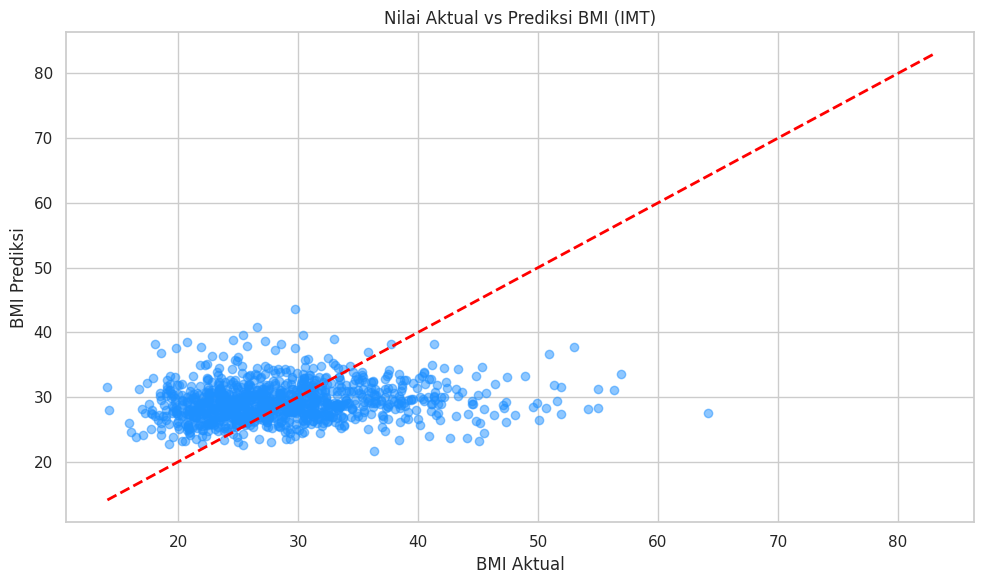

In [110]:
# Visualisasi hubungan antara nilai aktual dan prediksi
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='dodgerblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', linewidth=2)
plt.title('Nilai Aktual vs Prediksi BMI (IMT)')
plt.xlabel('BMI Aktual')
plt.ylabel('BMI Prediksi')
plt.grid(True)
plt.tight_layout()
plt.show()


--- Tingkat Kepentingan Fitur ---
DR1TTFAT    0.252173
DR1TPROT    0.251826
DR1TKCAL    0.244401
RIDAGEYR    0.188326
SMQ020      0.024993
RIAGENDR    0.019292
PAQ650      0.018990
dtype: float64


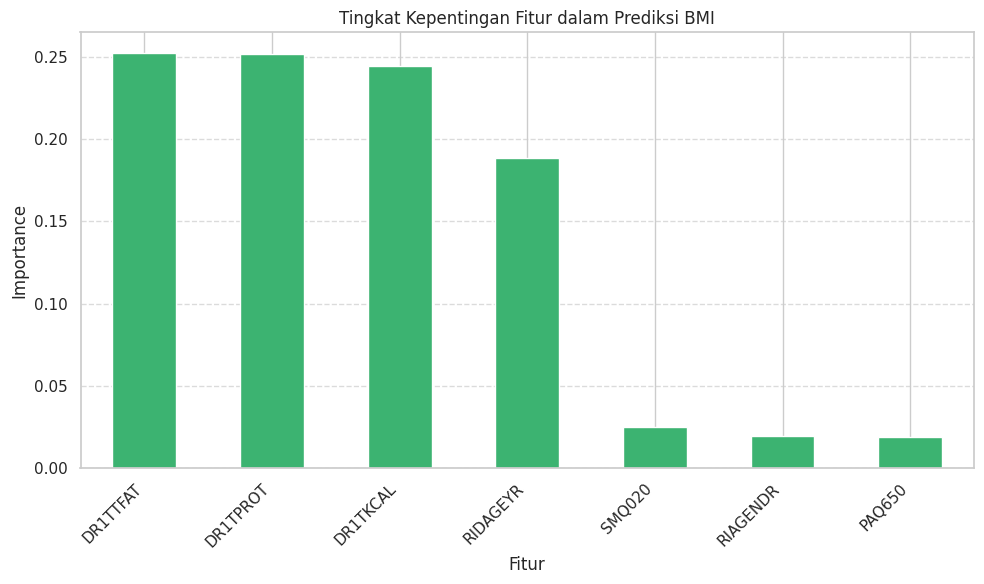

In [111]:
# Ambil tingkat kepentingan fitur dari model
feature_importances = pd.Series(
    rf_regressor.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

# Tampilkan nilai numerik pentingnya
print("\n--- Tingkat Kepentingan Fitur ---")
print(feature_importances)

# Visualisasi dalam bentuk bar chart
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='mediumseagreen')
plt.title('Tingkat Kepentingan Fitur dalam Prediksi BMI')
plt.ylabel('Importance')
plt.xlabel('Fitur')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#**6. Analisis**

Evaluasi Model:
- **R-squared (R²)**: Nilai R² negatif (misal: -0.05) menunjukkan bahwa model regresi Random Forest tidak mampu menjelaskan variasi nilai BMI lebih baik dari prediksi rata-rata.
- **MAE** sebesar ~5.4 dan **MSE** sekitar 50-an mengindikasikan error yang cukup besar untuk satuan BMI.

Interpretasi Visual:
- Pada scatter plot, titik-titik prediksi tersebar jauh dari garis diagonal merah. Ini mengonfirmasi bahwa model sering meleset dari nilai sebenarnya.
- Variabel diet seperti **lemak (DR1TTFAT)**, **protein (DR1TPROT)**, dan **kalori (DR1TKCAL)** mendominasi pentingnya fitur, namun kontribusinya belum cukup menjelaskan variasi BMI secara akurat.

Insight:
- **Fitur diet** memang memiliki pengaruh kuat, tetapi tidak cukup bila berdiri sendiri.
- **Usia** memberi kontribusi moderat, sedangkan **status merokok**, **aktivitas fisik**, dan **jenis kelamin** memiliki pengaruh kecil menurut model.

Rekomendasi Perbaikan:
1. **Tambahkan Fitur Baru**: Gunakan data dari `labs.csv` seperti kolesterol, glukosa, trigliserida, atau tekanan darah dari `examination.csv`.
2. **Feature Engineering**: Buat rasio nutrisi seperti protein/kalori, lemak/kalori.
3. **Imputasi Nilai Hilang**: Gunakan median atau KNN imputer daripada drop rows.
4. **Coba Model Lain**: Seperti Gradient Boosting Regressor, SVR, atau bahkan regresi linier sederhana sebagai baseline.
5. **Scaling**: Jika beralih ke model sensitif skala (seperti SVR), gunakan normalisasi atau standarisasi fitur numerik.

Kesimpulan:
Model saat ini masih underfitting. Namun pipeline sudah benar dan siap dikembangkan lebih lanjut dengan fitur tambahan dan eksplorasi teknik baru.

In [113]:
# Inisialisasi scaler
scaler = StandardScaler()

# Fit dan transform pada data latih
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
# Inisialisasi dan latih model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prediksi
y_pred_lr = lr_model.predict(X_test)

# Evaluasi performa
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Tampilkan hasil
print("=== Linear Regression ===")
print(f"R² Score: {r2_lr:.4f}")
print(f"RMSE    : {rmse_lr:.4f}")

=== Linear Regression ===
R² Score: 0.0022
RMSE    : 6.9450


In [115]:
# Inisialisasi dan latih model SVR
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Prediksi
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluasi performa
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

# Tampilkan hasil
print("=== Support Vector Regressor ===")
print(f"R² Score: {r2_svr:.4f}")
print(f"RMSE    : {rmse_svr:.4f}")

=== Support Vector Regressor ===
R² Score: 0.0046
RMSE    : 6.9367


In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Inisialisasi model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi
y_pred_rf = rf_model.predict(X_test)

# Evaluasi
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("=== Random Forest Regressor ===")
print(f"R² Score: {r2_rf:.4f}")
print(f"RMSE    : {rmse_rf:.4f}")

=== Random Forest Regressor ===
R² Score: -0.0092
RMSE    : 6.9847


In [116]:
from sklearn.ensemble import GradientBoostingRegressor

# Inisialisasi dan latih model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

# Prediksi
y_pred_gbr = gbr_model.predict(X_test)

# Evaluasi performa
r2_gbr = r2_score(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

# Tampilkan hasil
print("=== Gradient Boosting Regressor ===")
print(f"R² Score: {r2_gbr:.4f}")
print(f"RMSE    : {rmse_gbr:.4f}")

=== Gradient Boosting Regressor ===
R² Score: 0.0146
RMSE    : 6.9019


In [120]:
# Buat tabel hasil evaluasi
results = pd.DataFrame({
    "Model": ["Random Forest", "Linear Regression", "SVR", "Gradient Boosting"],
    "R² Score": [r2_rf, r2_lr, r2_svr, r2_gbr],
    "RMSE": [rmse_rf, rmse_lr, rmse_svr, rmse_gbr]
})

# Urutkan berdasarkan R² Score tertinggi
results_sorted = results.sort_values(by="R² Score", ascending=False).reset_index(drop=True)
print(results_sorted)

               Model  R² Score      RMSE
0  Gradient Boosting  0.014560  6.901908
1                SVR  0.004614  6.936651
2  Linear Regression  0.002225  6.944967
3      Random Forest -0.009222  6.984694
